> # TODO
>
> - [1 Cycle](https://github.com/nachiket273/One_Cycle_Policy/blob/master/CLR.ipynb) (superconvergence)
> - Try better models (resnet34, resnet50)
> - Bigger input size (480) using adaptative pooling, final layers then:
>   - -> [AdaptiveMaxPool1d](https://pytorch.org/docs/stable/nn.html#adaptivemaxpool1d) -> Linear
>   - -> Conv2d(512, 4, 3, padding=1) -> AdaptiveAvgPool2d(1) -> view(input.size(0), -1) -> LogSoftmax()
> - Bigger batch size
> - Balance the data
> - Metrics: mAP
> - Metrics: Confusion matrix
> - Metrics: 10-fold crossvalidation
> - **Use libjpeg-turbo** or **PyVips** to speed up jpeg image I/O from the disk.
> - Use **albumentations**for GPU utilization.

> # DONE
> - Use [lr_finder](https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0)
> - 2nd train unfreezed (or partially unfreezed)
> - Fix num_workers = 4  (no es posible en windows)
> - Set validation and test set and train
> - Metrics
>   - Loss
>   - Accuracy

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import clear_output
from fastprogress import master_bar, progress_bar
import pathlib
import PIL
from tqdm import tqdm
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("PyTorch Version: ",torchvision.__version__)

# plt.xkcd();  # commic plots plt.rcdefaults() to disable

PyTorch Version:  0.4.1
PyTorch Version:  0.2.1


# Load data

In [2]:
# Data hyperparameters
csv_file    = pathlib.Path("D:/Datasets/TFM/histologyDS2828/imageClasses.txt")
data_dir    = pathlib.Path("D:/Datasets/TFM/histologyDS2828/imgs")
val_percent = 0.3
num_workers = 0  # 4 when is fixed
batch_size  = 64
num_classes = 4
scale       = 360
input_shape = 480 #224  # 480
mean        = [0.485, 0.456, 0.406] #[0.5, 0.5, 0.5]
std         = [0.229, 0.224, 0.225] #[0.5, 0.5, 0.5]

class histologyDataset(Dataset):

	def __init__(self, csv_file, data_dir, subset):
		self.labels          = pd.read_csv(csv_file, header=None, delim_whitespace=True)
		self.labels_map      = {0 : "conective tissue", 1 : "ephitelial tissue", 2 : "muscular tissue", 3 : "nervous tissue"};
		self.data_dir        = data_dir
		self.subset          = subset
		self.data_transforms = {
			"train": transforms.Compose([
				#transforms.Resize(scale),
				transforms.RandomResizedCrop(input_shape),
				transforms.RandomHorizontalFlip(),
				transforms.RandomVerticalFlip(),
				transforms.RandomRotation(degrees=90),
				transforms.ToTensor(),
				transforms.Normalize(mean, std)]),
			"val": transforms.Compose([
				#transforms.Resize(scale),
				transforms.CenterCrop(input_shape),
				transforms.ToTensor(),
				transforms.Normalize(mean, std)]),
			"show": transforms.Compose([])}

	def __len__(self):
		return len(self.labels)

	def __getitem__(self, idx):
		img_name = data_dir / (self.labels.iloc[idx, 0])
		image    = PIL.Image.open(img_name)
		image    = self.data_transforms[self.subset](image)
		label    = self.labels.iloc[idx, 1] - 1
		return image, label

dataset = {x: histologyDataset(csv_file, data_dir, x) for x in ["train", "val", "show"]}
dataloader = {x: DataLoader(dataset[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in ['train', 'val']}
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}
print("There are", dataset_sizes["val"], "images in the dataset.")

# inputs, labels = next(iter(dataloader["val"]))

There are 2828 images in the dataset.


# Check if data is balanced

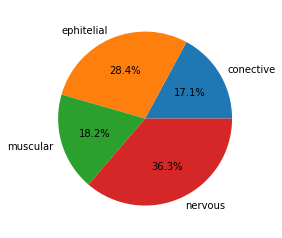

In [3]:
labels = 'conective', 'ephitelial', 'muscular', 'nervous'
count = [0, 0, 0, 0]

for i in range(len(dataset["val"])):
	class_number = dataset["val"].labels.iloc[i, 1]
	count[class_number-1] += 1

labels2 = [a+": "+str(b) for a, b in zip(labels, count)]
plt.pie(count, labels=labels, autopct='%1.1f%%');

# Show data

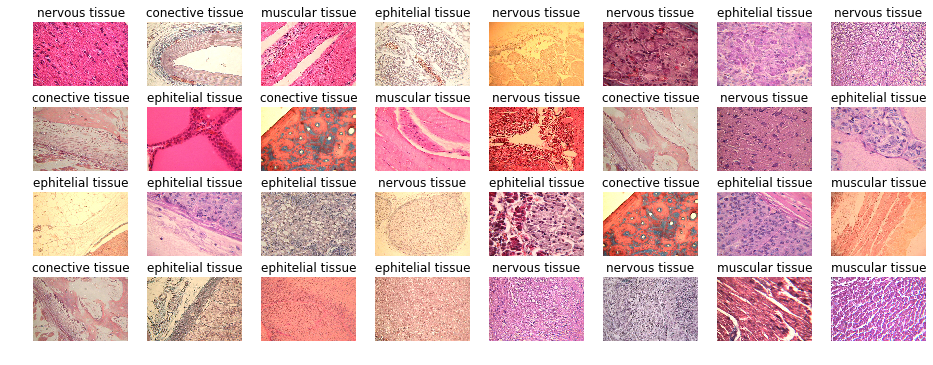

In [4]:
fig = plt.figure(figsize=(16,6));
columns = 8;
rows = 4;
for i in range(1, columns*rows +1):
    idx = np.random.randint(len(dataset["show"]));
    img, lbl = dataset["show"][idx]
    
    fig.add_subplot(rows, columns, i)
    
    plt.title(dataset["val"].labels_map[lbl])
    plt.axis('off')
    plt.imshow(img)
plt.show()

# Model: Resnet

In [5]:
pretrained    = True
model         = torchvision.models.resnet18(pretrained=pretrained) # resnet50
learning_rate = 0.01
momentum      = 0.9
weight_decay  = 1e-4
device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def save_checkpoint(is_best, filename='histology.pth.tar'):
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

def load_checkpoint(filename='histology.pth.tar'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

def see_params_to_learn():
    print("\nParams to learn:")
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Finetune the last layer
def freeze():
    for param in model.parameters():
        param.requires_grad = False

def partial_freeze(n):
    for i, (name, child) in enumerate(model.named_children()):
        if i < n:
            print(i+1,"frozen\t(",name,")")
            for param in child.parameters():
                param.requires_grad = False
        else:
            print(i+1,"unfrozen\t(",name,")")
            for param in child.parameters():
                param.requires_grad = True

# Finetune the whole model
def unfreeze():
    for param in model.parameters():
        param.requires_grad = True


freeze()

model.fc = nn.Linear(model.fc.in_features, num_classes) # new layer unfreezed by default

# Send the model to GPU
model = model.to(device)

print("Model:")
for i, (name, child) in enumerate(model.named_children()):
    print("\t("+str(i+1)+") "+name)

see_params_to_learn()
        
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(params_to_update, lr=learning_rate);

Model:
	(1) conv1
	(2) bn1
	(3) relu
	(4) maxpool
	(5) layer1
	(6) layer2
	(7) layer3
	(8) layer4
	(9) avgpool
	(10) fc

Params to learn:
	 fc.weight
	 fc.bias


# LR finder

The learning rate finder looks for the optimal learning rate to start the training. The technique is quite simple. For one epoch:

- Start with a very small learning rate (around 1e-8) and increase the learning rate linearly.
- Plot the loss at each step of LR.
- Stop the learning rate finder when loss stops going down and starts increasing.

A graph is created with the x axis having learning rates and the y axis having the losses.

[Webpage 1](https://medium.com/coinmonks/training-neural-networks-upto-10x-faster-3246d84caacd)
[Webpage 2](https://github.com/nachiket273/One_Cycle_Policy/blob/master/CLR.ipynb)

In [ ]:
def update_lr(optimizer, lr):
	for g in optimizer.param_groups:
		g['lr'] = lr

def update_mom(optimizer, mom):
	for g in optimizer.param_groups:
		g['momentum'] = mom

def findLR(model, optimizer, criterion, trainloader, init_value=1e-5, final_value=100):
    
	save_checkpoint(True) # save current model
	model.train()         # setup model for training configuration

	num = len(trainloader) - 1 # total number of batches
	mult = (final_value / init_value) ** (1/num)

	losses = []
	lrs = []
	best_loss = 0.
	avg_loss = 0.
	beta = 0.98 # the value for smooth losses
	lr = init_value

	for batch_num, (inputs, targets) in enumerate(tqdm(trainloader, total=len(trainloader))):

		update_lr(optimizer, lr)

		batch_num += 1 # for non zero value
		inputs, targets = inputs.to(device), targets.to(device) # convert to cuda for GPU usage

		optimizer.zero_grad() # clear gradients
		outputs = model(inputs) # forward pass
		loss = criterion(outputs, targets) # compute loss

		#Compute the smoothed loss to create a clean graph
		avg_loss = beta * avg_loss + (1-beta) *loss.item()
		smoothed_loss = avg_loss / (1 - beta**batch_num)

		#Record the best loss
		if smoothed_loss < best_loss or batch_num==1:
			best_loss = smoothed_loss

		# append loss and learning rates for plotting
		lrs.append(lr) #lrs.append(math.log10(lr)) # Plot modification
		losses.append(smoothed_loss)

		# Stop if the loss is exploding
		if batch_num > 1 and smoothed_loss > 4 * best_loss:
			break

		# backprop for next step
		loss.backward()
		optimizer.step()

		# update learning rate
		lr = mult*lr
        
	load_checkpoint()   # restore original model

	plt.xlabel('Learning Rates')
	plt.ylabel('Losses')
	plt.semilogx(lrs[10:-5], losses[10:-5]) #plt.plot(lrs, losses) # Plot modification
	plt.show()

In [ ]:
findLR(model, optimizer, criterion, dataloader["train"])

# Train

Live plot inspired from [this](https://github.com/stared/livelossplot)

In [6]:
def draw_plot(metrics):

	# Plot the metrics
	#clear_output(wait=True)
	#plt.figure(figsize=figsize)

	# Loss
	plt.subplot(1, 2, 1)
	x_range = list(range(1, len(metrics["train"]["loss"]) + 1))
	plt.plot(x_range, metrics["train"]["loss"], label="training")
	#plt.plot(x_range, metrics["val"]["loss"], label="validation")
	plt.title("Loss")
	plt.xlabel('epoch')
	plt.legend(loc='center right')

	# Loss
	plt.subplot(1, 2, 2)
	x_range = range(1, len(metrics["train"]["acc"]) + 1)
	plt.plot(x_range, metrics["train"]["acc"], label="training")
	#plt.plot(x_range, metrics["val"]["acc"], label="validation")
	plt.title("Accuracy")
	plt.xlabel('epoch')
	plt.legend(loc='center right')

	plt.tight_layout()
	plt.show();

In [7]:
metrics = { 'train': {'loss' : [], 'acc': [0]},
            'val':   {'loss' : [], 'acc': [0]}}

def train(num_epochs):

	# Decay LR by a factor of 0.1 every 7 epochs
	scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

	since = time.time()
	best_acc = 0.0
	#best_model_wts = copy.deepcopy(model.state_dict())

	mb  = master_bar(range(num_epochs))
	mb.names = ['train', 'val']
	mb.write("Epoch\tTrn_loss\tVal_loss\tTrn_acc\t\tVal_acc")
	# Iterate epochs
	#for epoch in range(num_epochs):
	for epoch in mb:

		# Each epoch has a training and validation phase
		for phase in ['train', 'val']:
			if phase == 'train':
				scheduler.step() # Scheduling the learning rate
				model.train()    # Set model to training mode
			else:
				model.eval()     # Set model to evaluate mode

			running_loss     = 0.0
			running_corrects = 0

			# Iterate over data
			#for inputs, labels in dataloader[phase]:
			for inputs, labels in progress_bar(dataloader[phase], parent=mb):
				inputs = inputs.to(device)
				labels = labels.to(device)

				optimizer.zero_grad()                  # zero the parameter gradients
				outputs = model(inputs)                # forward
				preds = torch.argmax(outputs, dim=1)   # prediction
				loss = criterion(outputs, labels)      # loss
				if phase == 'train': loss.backward()   # backward 
				if phase == 'train': optimizer.step()  # optimize

				# statistics
				running_loss     += loss.item() * inputs.size(0)
				running_corrects += torch.sum(preds == labels.data)

			epoch_loss = running_loss / dataset_sizes[phase]
			epoch_acc  = running_corrects.double() / dataset_sizes[phase]
			metrics[phase]["loss"].append(epoch_loss)
			metrics[phase]["acc"].append(epoch_acc)
			#draw_plot(metrics)

			# deep copy the model
			if phase == 'val' and epoch_acc > best_acc:
				best_acc = epoch_acc
				#best_model_wts = copy.deepcopy(model.state_dict())

		x = list(range(len(metrics["train"]["acc"])))
		graphs = [[x,metrics["train"]["acc"]], [x,metrics["val"]["acc"]]]
		mb.update_graph(graphs)
		mb.write("{}/{}\t{:06.6f}\t{:06.6f}\t{:06.6f}\t{:06.6f}".format(epoch+1, num_epochs,
			metrics["train"]["loss"][-1], metrics["val"]["loss"][-1],
			metrics["train"]["acc"][-1],  metrics["val"]["acc"][-1]))

	time_elapsed = time.time() - since
	print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
	print('Best val Acc: {:4f}'.format(best_acc))

	# load best model weights
	#model.load_state_dict(best_model_wts)

In [8]:
train(num_epochs=2) #4

RuntimeError: size mismatch, m1: [64 x 41472], m2: [512 x 4] at c:\programdata\miniconda3\conda-bld\pytorch_1533096106539\work\aten\src\thc\generic/THCTensorMathBlas.cu:249

In [ ]:
unfreeze()

Total time: 01:45
Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1/3	0.626975	0.773289	0.753536	0.721358   (00:35)
2/3	0.630034	0.769613	0.766620	0.739038   (00:35)
3/3	0.601007	0.757579	0.776167	0.743989   (00:35)

Training complete in 1m 45s
Best val Acc: 0.743989


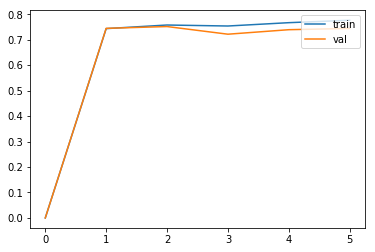

In [18]:
train(num_epochs=3)

# Confusion matrix

In [ ]:
classes = 'conective', 'ephitelial', 'muscular', 'nervous'

batch   = next(iter(dataloader))
images = batch['image'].to(device)
labels = batch['label'].to(device)
outputs = model(images)           # forward

y_true = labels.cpu().numpy()
y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
_, y_pred2 = torch.max(outputs, 1).cpu().numpy()

cm = confusion_matrix(y_true, y_pred)
print(y_true)
print(y_pred)
print(y_pred2)
print(cm)

#plt.matshow(cm)
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], fontsize=18, horizontalalignment="center", color="white")
plt.tight_layout()